In [73]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm, tqdm_notebook
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import warnings
import matplotlib.pyplot as plt
import math


warnings.filterwarnings('ignore')
train_path = '../../input/hy_round1_train_20200102'
test_path = '../../input/hy_round1_testA_20200102'

In [6]:
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

print(f"训练样本：{len(train_files)}")
print(f"测试样本：{len(test_files)}")

训练样本：7000
测试样本：2000


In [7]:
train_files[:3]

['0.csv', '1.csv', '10.csv']

In [8]:
test_files[:3]

['7000.csv', '7001.csv', '7002.csv']

### 维度检查

随便挑选几个数据集检查一下数据，维度并不统一。

In [33]:
df = pd.read_csv(f'{train_path}/6966.csv')
print(f"作业类型：{df['type'].unique()}")
print(f"数据维度：{df.shape}")

作业类型：['围网']
数据维度：(389, 7)


In [34]:
df = pd.read_csv(f'{train_path}/66.csv')
print(f"作业类型：{df['type'].unique()}")
print(f"数据维度：{df.shape}")

作业类型：['围网']
数据维度：(353, 7)


In [35]:
df.head()

,渔船ID,x,y,速度,方向,time,type
0,66,6.606038e+06,5.900305e+06,0.0,0,1123 23:52:01,围网
1,66,6.606038e+06,5.900305e+06,0.0,0,1123 23:42:01,围网
2,66,6.606038e+06,5.900305e+06,0.0,0,1123 23:32:01,围网
3,66,6.606038e+06,5.900305e+06,0.0,0,1123 23:22:01,围网
4,66,6.606038e+06,5.900305e+06,0.0,0,1123 23:12:01,围网


In [36]:
df.shape[0]

353

### 全部维度检查

检查内容：

- 一个ID是否多种作业？
- 数据shape最大最小？

In [38]:
# train

empty_type = []
one_type = []
mul_type = []
strange_type = []
max_report = 0
min_report = 99999

for file in tqdm_notebook(train_files):
    df = pd.read_csv(f'{train_path}/{file}')
    
    # 最长最短数据统计
    if df.shape[0] > max_report:
        max_report      = df.shape[0]
        max_report_file = file
    if df.shape[0] < min_report:
        min_report      = df.shape[0]
        min_report_file = file
    
    # 作业类型统计
    if len(df['type'].unique()) == 0:
        empty_type.append(file)
    elif len(df['type'].unique()) == 1:
        one_type.append(file)
    elif len(df['type'].unique()) > 1:
        mul_type.append(file)
    else:
        strange_type.append(file)
        
    # 缺失值
    for column in df.columns:
        if df[column].isnull().any():
            print(f"文件：{file} 有数据缺失？")

print(f"最长的report:{max_report}，文件是：{max_report_file}")
print(f"最短的report:{min_report}，文件是：{min_report_file}")

print(f"空作业类型数量：{len(empty_type)}")
print(f"单作业类型数量：{len(one_type)}")
print(f"多作业类型数量：{len(mul_type)}")
print(f"非作业类型数量：{len(strange_type)}")


最长的report:3969，文件是：4924.csv
最短的report:12，文件是：254.csv
空作业类型数量：0
单作业类型数量：7000
多作业类型数量：0
非作业类型数量：0


In [41]:
# test

empty_type = []
one_type = []
mul_type = []
strange_type = []
max_report = 0
min_report = 99999

for file in tqdm_notebook(test_files):
    df = pd.read_csv(f'{test_path}/{file}')
    
    # 最长最短数据统计
    if df.shape[0] > max_report:
        max_report      = df.shape[0]
        max_report_file = file
    if df.shape[0] < min_report:
        min_report      = df.shape[0]
        min_report_file = file
    
    # 作业类型统计
    # pass
        
    # 缺失值
    for column in df.columns:
        if df[column].isnull().any():
            print(f"文件：{file} 有数据缺失？")

print(f"最长的report:{max_report}，文件是：{max_report_file}")
print(f"最短的report:{min_report}，文件是：{min_report_file}")

# print(f"空作业类型数量：{len(empty_type)}")
# print(f"单作业类型数量：{len(one_type)}")
# print(f"多作业类型数量：{len(mul_type)}")
# print(f"非作业类型数量：{len(strange_type)}")


最长的report:3891，文件是：7225.csv
最短的report:21，文件是：7233.csv


### 图片绘制

In [147]:
df = pd.read_csv(f'{train_path}/4924.csv')
print(f"作业类型：{df['type'].unique()}")
print(f"数据维度：{df.shape}")

作业类型：['围网']
数据维度：(3969, 7)


In [148]:
df.head()

,渔船ID,x,y,速度,方向,time,type
0,4924,6.328956e+06,5.291393e+06,0.38,103,1113 23:59:30,围网
1,4924,6.328956e+06,5.291393e+06,0.05,0,1113 23:58:27,围网
2,4924,6.328956e+06,5.291393e+06,0.00,0,1113 23:57:24,围网
3,4924,6.328956e+06,5.291393e+06,0.05,0,1113 23:56:20,围网
4,4924,6.328956e+06,5.291393e+06,0.05,0,1113 23:55:17,围网


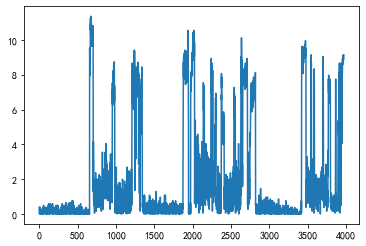

In [149]:
plt.plot(df['速度'])

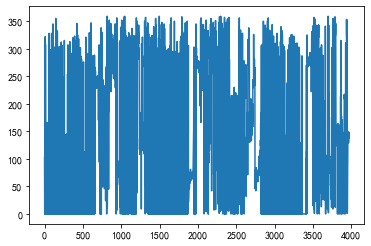

In [150]:
# 此方向无意义
plt.plot(df['方向'])

In [161]:
def df_angle_handle(dataframe):
    if '方向' in dataframe.columns:
        sin_list = []
        cos_list = []
        for angle in dataframe['方向'].values:
            sin_list.append(math.sin(math.radians(angle)))
            cos_list.append(math.cos(math.radians(angle)))
        dataframe['sin_angle'] = sin_list
        dataframe['cos_angle'] = cos_list
        dataframe = dataframe.drop('方向', axis=1)
    else:
        print("没有方向列或已经处理完毕")
    return dataframe

In [162]:
df = df_angle_handle(df)

没有方向列或已经处理完毕


In [163]:
df

,渔船ID,x,y,速度,time,type,sin_angle,cos_angle
0,4924,6.328956e+06,5.291393e+06,0.38,1113 23:59:30,围网,0.974370,-0.224951
1,4924,6.328956e+06,5.291393e+06,0.05,1113 23:58:27,围网,0.000000,1.000000
2,4924,6.328956e+06,5.291393e+06,0.00,1113 23:57:24,围网,0.000000,1.000000
3,4924,6.328956e+06,5.291393e+06,0.05,1113 23:56:20,围网,0.000000,1.000000
4,4924,6.328956e+06,5.291393e+06,0.05,1113 23:55:17,围网,0.000000,1.000000
...,...,...,...,...,...,...,...,...
3964,4924,6.342718e+06,5.283126e+06,9.17,1111 00:04:36,围网,0.743145,-0.669131
3965,4924,6.342517e+06,5.283346e+06,8.96,1111 00:03:33,围网,0.515038,-0.857167
3966,4924,6.342316e+06,5.283566e+06,8.85,1111 00:02:30,围网,0.681998,-0.731354
3967,4924,6.342115e+06,5.283786e+06,9.07,1111 00:01:27,围网,0.559193,-0.829038


In [154]:
def show_one_path(df):
    plt.figure(figsize=(50,50))
    plt.plot(df['x'], df['y'])
    X = df['x'].values.flatten()
    Y = df['y'].values.flatten()
    U = df['sin_angle'].values.flatten()
    V = df['cos_angle'].values.flatten()
    plt.quiver(X, Y, U, V, angles="xy",color="#666666")
    
    cur_id = df['渔船ID'].iloc[0] 
    # 中文标题，必要时可以不用
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.title(f'渔船ID：{cur_id}', size=50)
    return 0

0

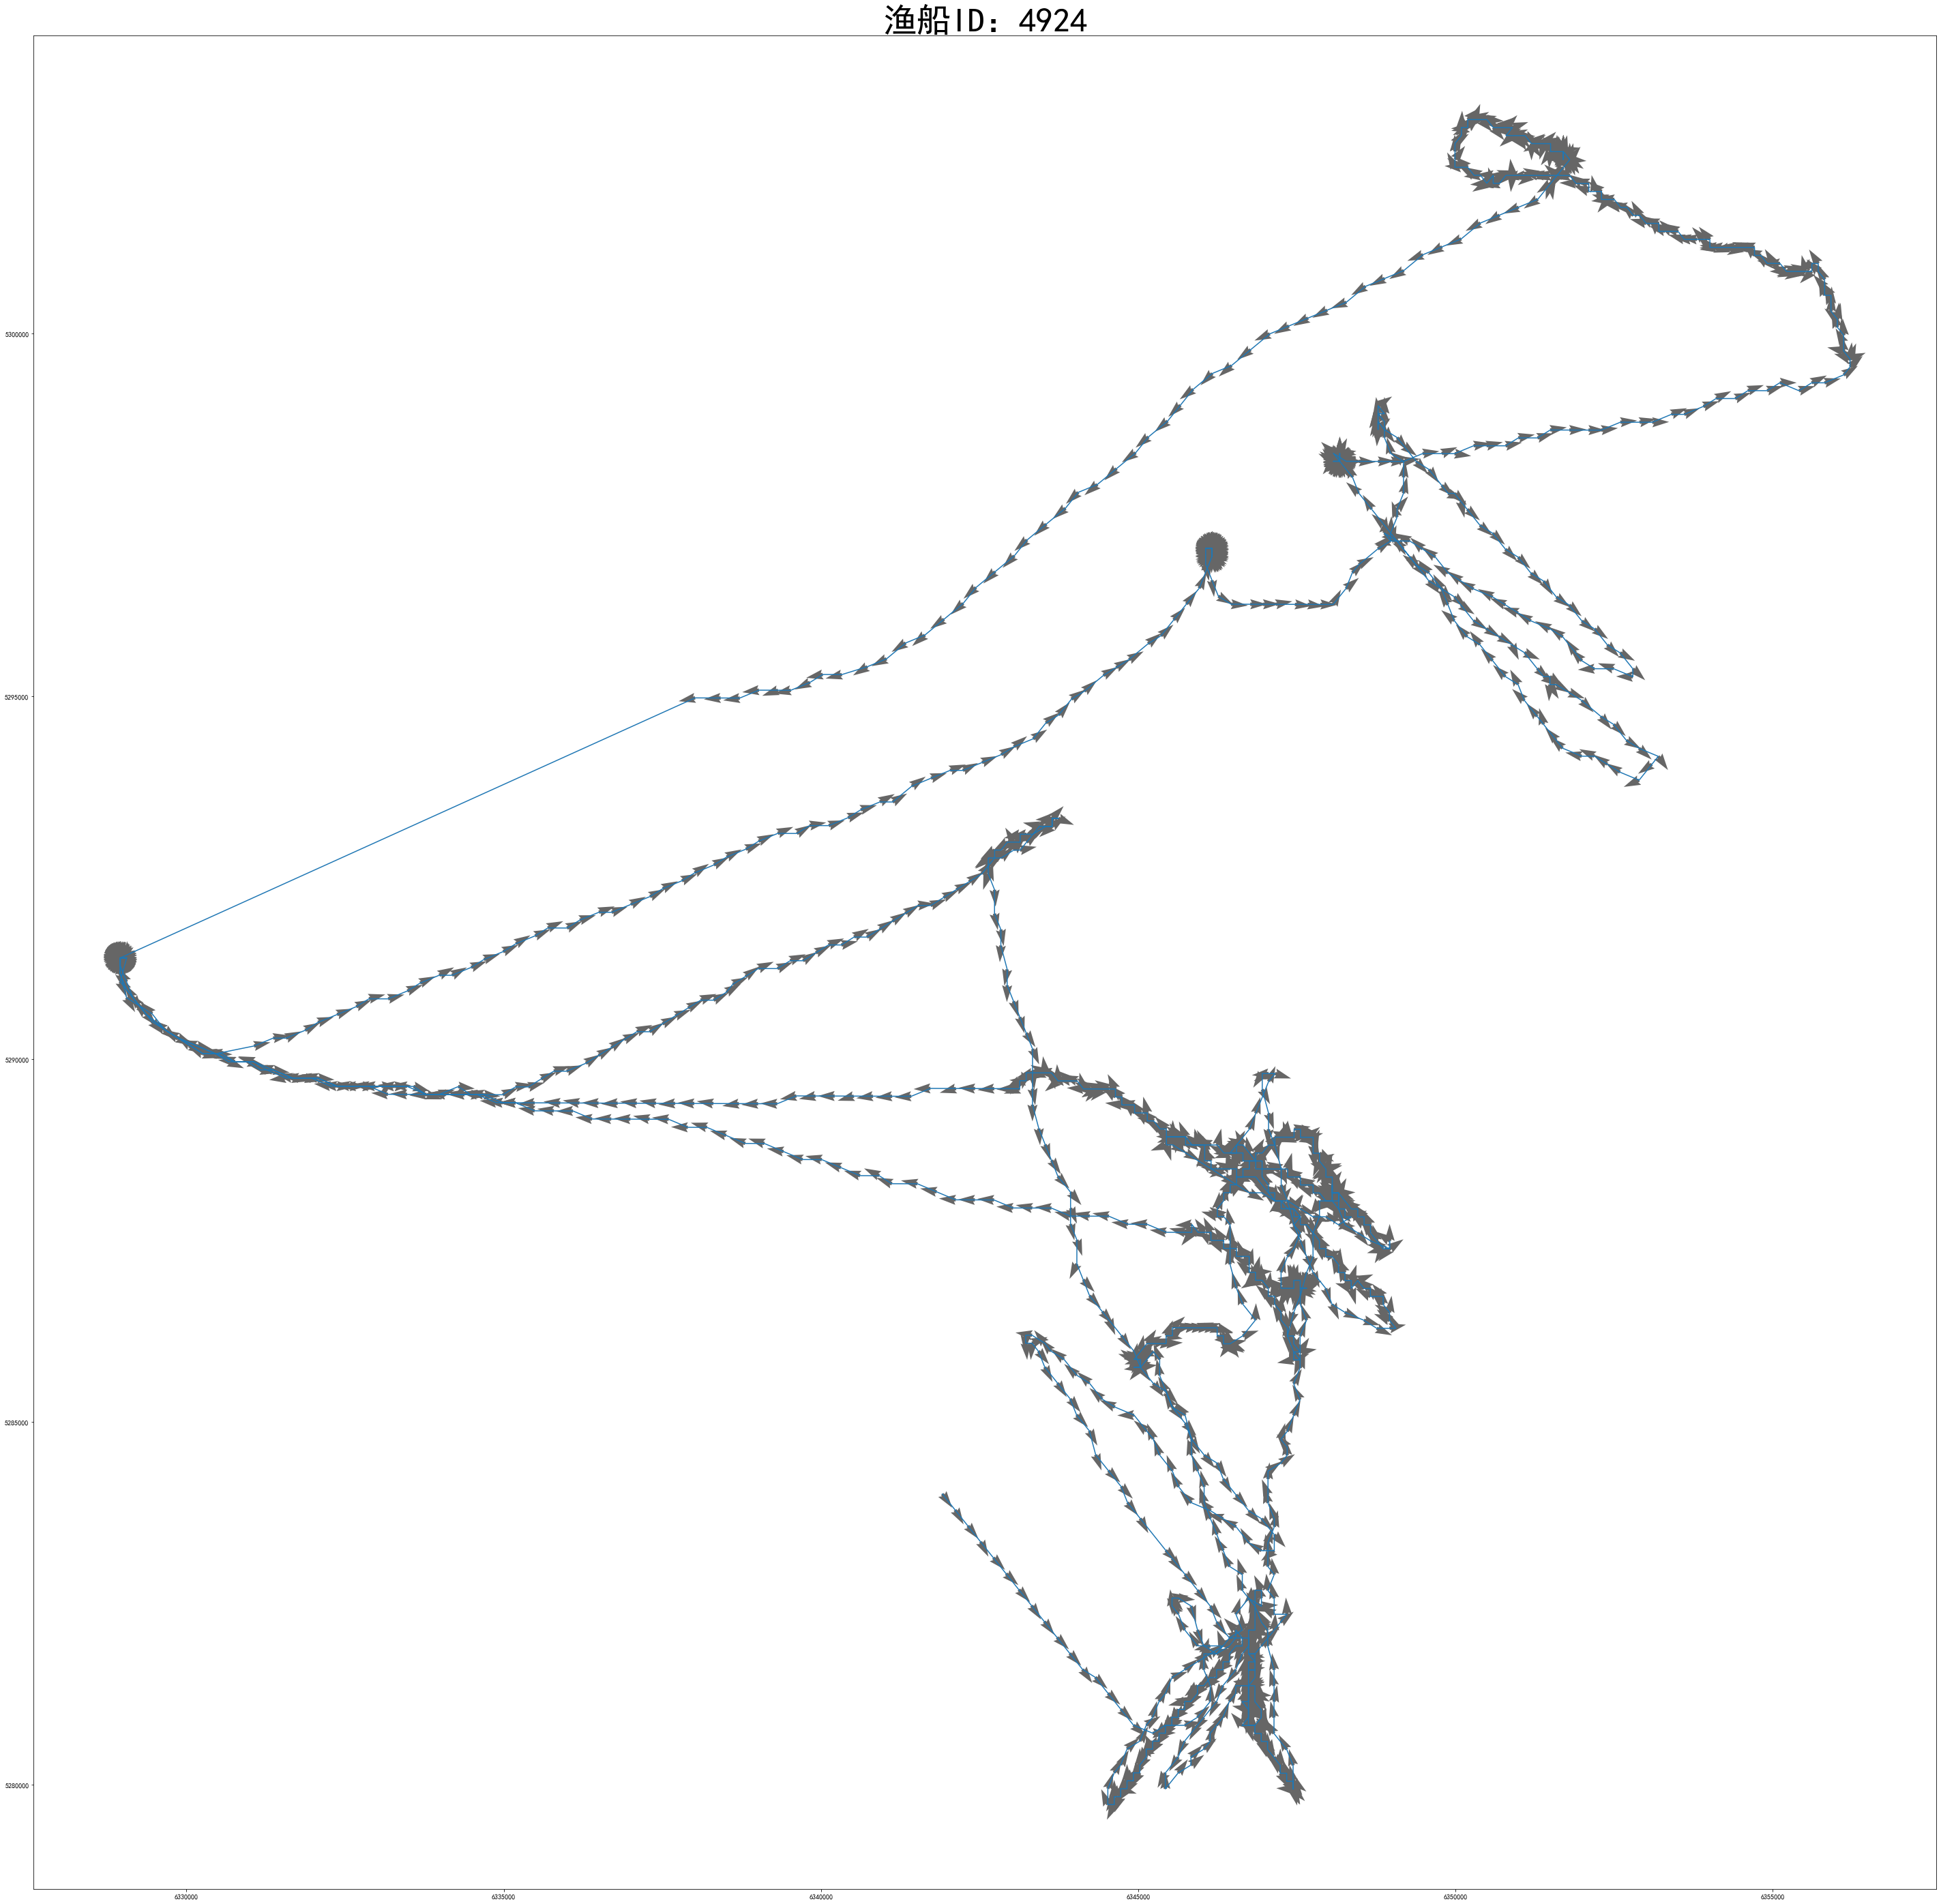

In [155]:
show_one_path(df)

In [21]:
ret = []
for file in tqdm(train_files):
    df = pd.read_csv(f'{train_path}/{file}')
    ret.append(df)
df = pd.concat(ret)
df.columns = ['ship','x','y','v','d','time','type']

100%|██████████| 7000/7000 [00:34<00:00, 260.00it/s]


In [ ]:
df.to_hdf('../input/train.h5', 'df', mode='w')

In [37]:
ret = []
for file in tqdm(test_files):
    df = pd.read_csv(f'{test_path}/{file}')
    ret.append(df)
df = pd.concat(ret)
df.columns = ['ship','x','y','v','d','time']

100%|██████████| 2000/2000 [00:08<00:00, 225.65it/s]


In [41]:
df.to_hdf('../input/test.h5', 'df', mode='w')

In [40]:
df.shape

(782378, 6)

In [38]:
df.head()

,渔船ID,x,y,速度,方向,time
0,8793,6.102450e+06,5.112760e+06,0.00,0,1106 23:56:34
1,8793,6.102450e+06,5.112760e+06,0.00,0,1106 23:46:34
2,8793,6.102450e+06,5.112760e+06,0.00,0,1106 23:37:31
3,8793,6.102450e+06,5.112760e+06,0.16,0,1106 23:26:34
4,8793,6.102450e+06,5.112760e+06,0.00,0,1106 23:16:34
